In [1]:
import mesa
import mesa_geo as mg
import geopandas as gpd
import matplotlib.pyplot as plt
import random

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely.geometry import Polygon, MultiPolygon

In [2]:
import requests

# buurten ex water (approx 517)
url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_BUURT_EXWATER&THEMA=gebiedsindeling"
ID = "Buurt"

# # wijken ex water (approx 110)
# url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_WIJK_EXWATER&THEMA=gebiedsindeling"
# ID = "Wijk"

# # gebieden ex water (approx 25)
# url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_GEBIED_EXWATER&THEMA=gebiedsindeling"
# ID = "Gebied"

# # stadsdelen ex water (approx 9)
# url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_STADSDEEL_EXWATER&THEMA=gebiedsindeling"
# ID = "Stadsdeel"

# # woningswaardes 2022
price_url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=WONINGWAARDE_2022&THEMA=woningwaarde"
price_ID = "LABEL"

r = requests.get(url)
geojson_ams = r.json()

r_price = requests.get(price_url)
geojson_ams_price = r_price.json()

In [3]:
len(geojson_ams['features'])


517

In [4]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# Function to create a GeoDataFrame from the given dataset
def create_gdf(data):
    geometries = []
    properties = []

    for feature in data:
        geom_type = feature['geometry']['type']
        coords = feature['geometry']['coordinates']
        
        if geom_type == 'Polygon':
            # Create a Polygon
            polygon = Polygon(shell=coords[0], holes=coords[1:] if len(coords) > 1 else None)
        elif geom_type == 'MultiPolygon':
            # Create a MultiPolygon
            polygons = []
            for polygon_coords in coords:
                polygon = Polygon(shell=polygon_coords[0], holes=polygon_coords[1:] if len(polygon_coords) > 1 else None)
                polygons.append(polygon)
            polygon = MultiPolygon(polygons)
        
        geometries.append(polygon)
        properties.append(feature['properties'])

    gdf = gpd.GeoDataFrame(properties, geometry=geometries)
    return gdf

# Assuming geojson_ams and geojson_ams_price are your datasets
data1 = geojson_ams['features']
data2 = geojson_ams_price['features']

# Create GeoDataFrames
gdf1 = create_gdf(data1)
gdf2 = create_gdf(data2)

# Perform a spatial join to find the nearest geometries
nearest_gdf = gpd.sjoin_nearest(gdf1, gdf2, how="left", distance_col="distance")

# Update the properties of the first dataset with the matched LABEL values
for index, row in nearest_gdf.iterrows():
    if 'LABEL' in row:
        data1[index]['properties']['LABEL'] = row['LABEL']

# Optionally, convert data1 back to a GeoDataFrame if needed
updated_gdf1 = create_gdf(data1)

# Print length of nearest_gdf for verification
print(len(nearest_gdf))

# Assuming you want to update the original geojson_ams['features'] with data1
geojson_ams['features'] = data1


1565


In [5]:
class State(mg.GeoAgent):
    def __init__(self, unique_id, model, geometry, crs):
        super().__init__(unique_id, model, geometry, crs)


class GeoModel(mesa.Model):
    def __init__(self):
        self.space = mg.GeoSpace()

        ac = mg.AgentCreator(agent_class=State, model=self)
        agents = ac.from_GeoJSON(GeoJSON=geojson_ams, unique_id=ID)
        self.space.add_agents(agents)

In [6]:
m = GeoModel()

/home/renan/documents/Uni/ABM/venv/lib/python3.12/site-packages/mesa_geo/geoagent.py:38: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  Agent.__init__(self, unique_id, model)
/home/renan/documents/Uni/ABM/venv/lib/python3.12/site-packages/mesa_geo/geospace.py:172: UserWarning: Converting State from crs EPSG:4326 to the crs of GeoSpace - EPSG:3857. Please check your crs settings if this is unintended, or set `GeoSpace.warn_crs_conversion` to `False` to suppress this warning message.
  self._check_agent(agent)


In [7]:
data1

[{'id': 1,
  'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[5.060128, 52.321072],
     [5.059857, 52.321254],
     [5.056662, 52.322805],
     [5.056761, 52.322924],
     [5.056825, 52.323125],
     [5.056646, 52.323161],
     [5.056634, 52.323209],
     [5.056698, 52.323477],
     [5.05164, 52.323735],
     [5.051675, 52.324313],
     [5.047635, 52.324586],
     [5.047666, 52.324961],
     [5.047788, 52.325501],
     [5.047791, 52.325532],
     [5.047781, 52.325555],
     [5.047759, 52.325581],
     [5.047724, 52.325607],
     [5.047689, 52.325622],
     [5.04765, 52.325634],
     [5.047603, 52.32564],
     [5.04755, 52.325643],
     [5.045612, 52.325668],
     [5.041009, 52.325104],
     [5.041013, 52.325354],
     [5.039611, 52.325478],
     [5.039622, 52.325532],
     [5.03752, 52.325689],
     [5.037619, 52.326054],
     [5.036138, 52.326197],
     [5.036066, 52.326005],
     [5.035973, 52.325698],
     [5.035025, 52.325857],
     [5.034942, 52.325648],


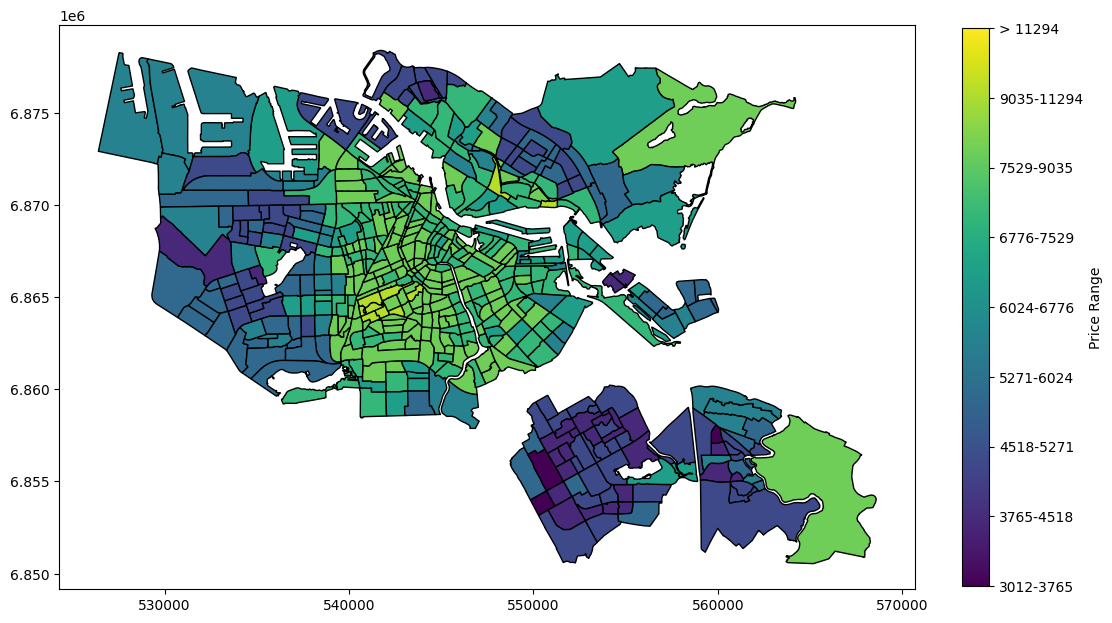

In [8]:
# Assuming `m.space.agents` contains the agents
geometries = []
agent_labels = []
price_ranges = []  # Assuming each agent has a price range string

for agent in m.space.agents:
    geometries.append(agent.geometry)
    price_ranges.append(agent.LABEL)

# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['price_range'] = price_ranges

# Define a colormap that represents a gradient from cheap to expensive
cmap = plt.get_cmap('viridis')  # You can choose any colormap here

# Define the range of price ranges in the order you want to assign colors
price_range_order = [
    '3012-3765',
    '3765-4518',
    '4518-5271',
    '5271-6024',
    '6024-6776',
    '6776-7529',
    '7529-9035',
    '9035-11294',
    '> 11294'
]

# Create a dictionary mapping each price range to a color using the colormap
colors = {price_range: cmap(idx / len(price_range_order)) for idx, price_range in enumerate(price_range_order)}

# Assign colors to each agent based on their price range
gdf['color'] = gdf['price_range'].map(colors.get)

# Plot the geometries with the specified colors
fig, ax = plt.subplots(figsize=(12, 10)) 
gdf.plot(ax=ax, edgecolor='black', color=gdf['color'])

# Add colorbar with specified fraction size
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=len(price_range_order) - 1))
sm.set_array([])  # You need to set an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, fraction=0.03)  # Adjust fraction as needed (0.03 is just an example)
cbar.set_ticks(range(len(price_range_order)))
cbar.set_ticklabels(price_range_order)
cbar.set_label('Price Range')


# Show the plot
plt.show()


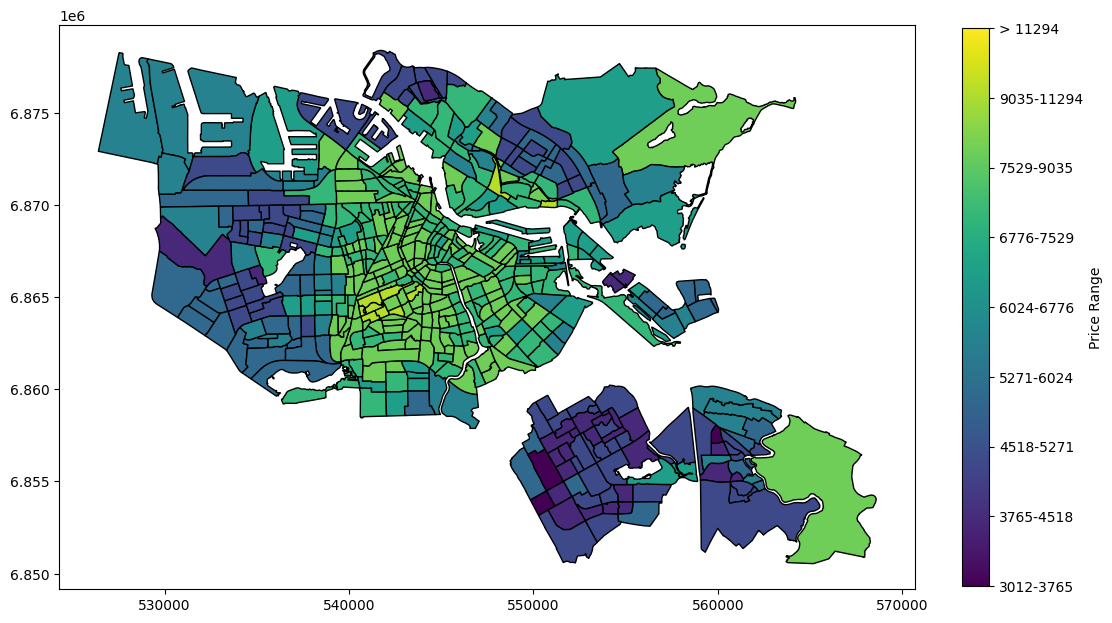

In [9]:
# Assuming `m.space.agents` contains the agents
geometries = []
agent_labels = []
price_ranges = []  # Assuming each agent has a price range string

for agent in m.space.agents:
    geometries.append(agent.geometry)
    price_ranges.append(agent.LABEL)

# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['price_range'] = price_ranges

# Define a colormap that represents a gradient from cheap to expensive
cmap = plt.get_cmap('viridis')  # You can choose any colormap here

# Define the range of price ranges in the order you want to assign colors
price_range_order = [
    '3012-3765',
    '3765-4518',
    '4518-5271',
    '5271-6024',
    '6024-6776',
    '6776-7529',
    '7529-9035',
    '9035-11294',
    '> 11294'
]

# Create a dictionary mapping each price range to a color using the colormap
colors = {price_range: cmap(idx / len(price_range_order)) for idx, price_range in enumerate(price_range_order)}

# Assign colors to each agent based on their price range
gdf['color'] = gdf['price_range'].map(colors.get)

# Plot the geometries with the specified colors
fig, ax = plt.subplots(figsize=(12, 10)) 
gdf.plot(ax=ax, edgecolor='black', color=gdf['color'])

# Add colorbar with specified fraction size
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=len(price_range_order) - 1))
sm.set_array([])  # You need to set an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, fraction=0.03)  # Adjust fraction as needed (0.03 is just an example)
cbar.set_ticks(range(len(price_range_order)))
cbar.set_ticklabels(price_range_order)
cbar.set_label('Price Range')


# Show the plot
plt.show()


In [25]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

# Sample GeoDataFrame (replace this with your actual gdf)
# gdf = gpd.read_file('path_to_your_file.shp')

# Create a function to generate a grid
def create_grid(gdf, cell_size):
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    minx, miny, maxx, maxy = bounds

    # Generate the coordinates for the grid
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)

    grid_cells = []
    for x in x_coords:
        for y in y_coords:
            # Create a cell
            cell = Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
            grid_cells.append(cell)

    # Create a GeoDataFrame from the grid cells
    grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
    grid_gdf.crs = gdf.crs

    return grid_gdf

# Define the cell size (e.g., 0.01 degrees for geographic coordinates or 1000 meters for projected coordinates)
cell_size = 800

# Create the grid
grid_gdf = create_grid(gdf, cell_size)

# Perform a spatial join to assign attributes from gdf to grid_gdf
joined_gdf = gpd.sjoin(grid_gdf, gdf, how='left', predicate='intersects')

# Fill NaNs or handle them
# Option 1: Remove NaN rows
joined_gdf = joined_gdf.dropna(subset=['price_range'])

# Assign colors to each agent based on their price range
joined_gdf['color'] = joined_gdf['price_range'].map(colors.get)


In [26]:
x_min = joined_gdf.total_bounds[0]
y_min = joined_gdf.total_bounds[1]

x_max = joined_gdf.total_bounds[2]
y_max = joined_gdf.total_bounds[3]

In [27]:
scaled_joined_gdf = joined_gdf.geometry.copy()

scaled_joined_gdf = scaled_joined_gdf.translate(xoff=-x_min, yoff=-y_min)
scaled_joined_gdf = scaled_joined_gdf.scale(xfact=50/(x_max-x_min), yfact=50/(x_max-x_min), origin=(0, 0))

joined_gdf.geometry = scaled_joined_gdf

In [28]:
joined_gdf['price_range']

27       6024-6776
28       6024-6776
29       6024-6776
30       6024-6776
31       6024-6776
           ...    
1820    9035-11294
1821    9035-11294
1822    9035-11294
1823    9035-11294
1824    9035-11294
Name: price_range, Length: 3010, dtype: object

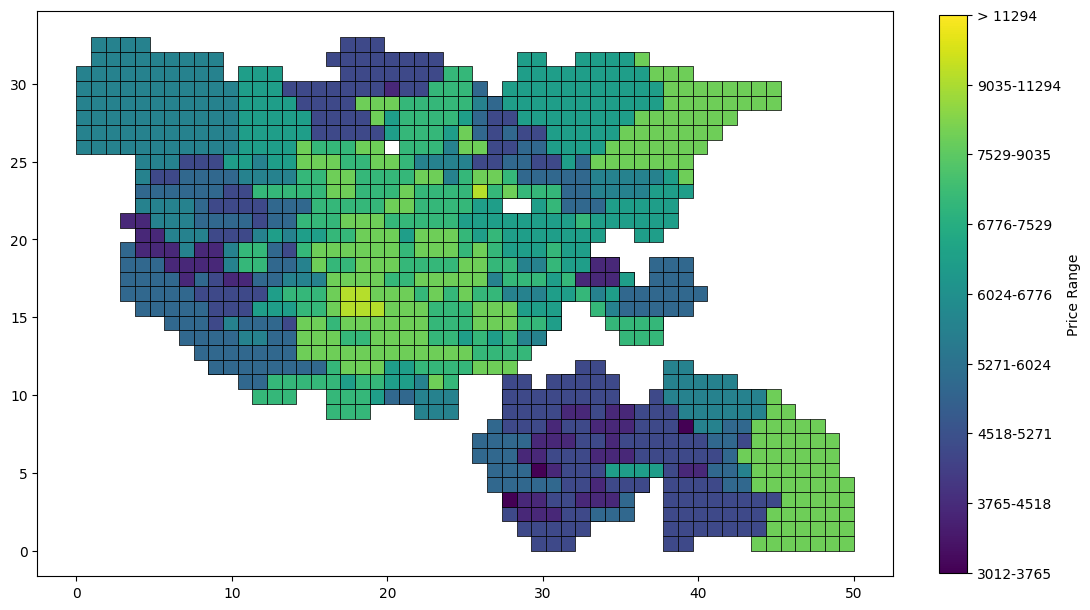

In [29]:
# Plot the geometries with the specified colors
fig, ax = plt.subplots(figsize=(12, 10)) 
joined_gdf.plot(ax=ax, edgecolor='black', color=joined_gdf['color'], linewidth=0.5)

# Add colorbar with specified fraction size
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=len(price_range_order) - 1))
sm.set_array([])  # You need to set an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, fraction=0.03)  # Adjust fraction as needed (0.03 is just an example)
cbar.set_ticks(range(len(price_range_order)))
cbar.set_ticklabels(price_range_order)
cbar.set_label('Price Range')

geojson_str = joined_gdf.to_json()
# Save to a GeoJSON file
with open('joined_gdf_50.geojson', 'w') as f:
    f.write(geojson_str)

# Show the plot
plt.show()